In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Manual seed, do not change so this is reproducible.
### First 4 digits of pi for good luck lol

In [4]:
torch.manual_seed(3141)

# Load Data, do not touch

In [5]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [6]:
train_directions = m["direction_YQ1"].flatten() - 1
train_directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [7]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [8]:
traj_origin.shape

(156, 3, 151)

In [9]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = train_directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

# Do not touch, this was tedious af

In [10]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

all_inputs = torch.tensor(traj[:, :, 0], dtype=torch.float32)
all_targets = torch.tensor(traj[:, :, :], dtype=torch.float32)

In [11]:
all_inputs.shape

torch.Size([156, 4])

In [12]:
def get_init_point(direction: int, n_points: int) -> np.ndarray:
    get_means = lambda: all_inputs.mean(axis=0)
    get_stds  = lambda: all_inputs.std(axis=0)
    
    xyz0 = [np.random.normal(loc=get_means()[i], scale=get_stds()[i], size=n_points) for i in range(3)]
    dirs = [np.ones(n_points) * direction]

    return np.column_stack(xyz0 + dirs)

In [13]:
get_init_point(0, 6)

array([[-0.20948253,  0.48419578,  0.58597028,  0.        ],
       [ 0.27882656,  0.46150174, -0.04934237,  0.        ],
       [-0.26896917, -0.00181341,  0.71678571,  0.        ],
       [ 0.09226965, -0.14844841,  0.12649631,  0.        ],
       [ 0.15867173,  0.37757723,  0.07592759,  0.        ],
       [ 0.15446424,  0.37515952, -0.10351015,  0.        ]])

# This arch works pretty well

In [14]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size, 3)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        out = self.linear(out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev

# Logistic regression to classify if the trajectory reaches the left or right target

In [16]:
log_reg = LogisticRegression()
log_reg.fit(all_targets[:, :3, -1], train_directions)

def target_accuracy(predictions, target_directions):
    return np.count_nonzero(
        log_reg.predict(
            np.vstack([p[-1] for p in predictions])
        ) == target_directions
    ) / target_directions.size

In [49]:
def target_accuracy_model(model):
    all_preds = torch.zeros(156, 150, 3).cuda()
    inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)

    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()
    
    for timepoint in range(150):
        pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
        all_preds[:, timepoint, :] = pred[0, :, 0, :]
        
    return target_accuracy(all_preds.detach().cpu().numpy(), train_directions)

# Training loop you can use to also test the pruned etc. models

In [46]:
def train(
    model: SimpleRNN,
    targets: torch.Tensor,
    optimizer: optim.Optimizer,
    lr0: int,
    loss_func: callable,
    n_epochs: int,
    gradient_ascent: bool = False,
    return_accuracy: bool = False
) -> SimpleRNN:
    """
    Parameters
    ----------

    SimpleRNN model instance

    `all_targets` created above

    optimizer, Adam seems to work well
    
    lr0, initial learning rate

    loss function, just MSE for now
    
    Returns
    -------
    
    SimpleRNN model instance, losses
    """

    losses = list()
    accs = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()

    for n_epoch in tqdm(range(n_epochs)):
        # give position and target direction [x, y, z, direction] of only first index!
        x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4) # [n_trajs, 1, (x0, y0, z0, dir_0)]
        y = all_targets.swapaxes(1, 2)[:, :, :3]

        output, hidden_prev = model(x.cuda(), hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        if not gradient_ascent:
            loss = loss_func(output, y.cuda())
        else:
            loss = make_ascent(loss_func(output, y.cuda()))
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduces learnign rate every 250 epochs, this helps A LOT
        if n_epoch % 250 == 0:
            lr0 = lr0 / 10
            for g in optimizer.param_groups:
                g['lr'] = lr0

        losses.append(loss.detach().cpu().numpy().item())
        
        if return_accuracy:
            accs.append(target_accuracy_model(model))
        else:
            accs = None
            
    
    return model, losses, accs

# Create the model

## these params seem to work well

In [18]:
torch.manual_seed(3141)

simple_rnn = SimpleRNN(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

In [19]:
lr = 0.001

simple_rnn, ls, ac = train(
    model=simple_rnn,
    targets=all_targets,
    optimizer=optim.Adam(simple_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=500
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 631.48it/s]


# all losses and last 10 losses printed

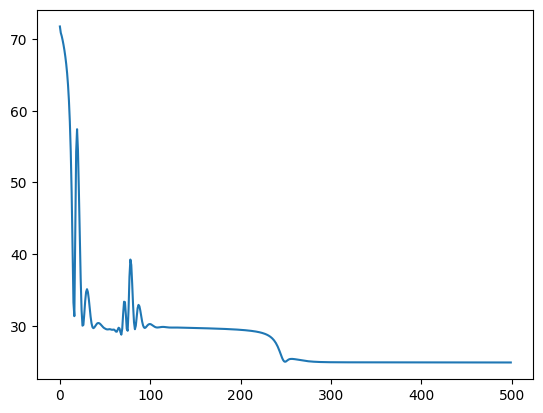

In [20]:
%matplotlib inline
plt.plot(ls)
plt.show()

### Last 10 losses, I get 24.8

In [21]:
ls[-10:]

[24.869638442993164,
 24.8695011138916,
 24.869384765625,
 24.869274139404297,
 24.86917495727539,
 24.869007110595703,
 24.86890411376953,
 24.868789672851562,
 24.86871337890625,
 24.868560791015625]

# Just a function to plot predictions

In [70]:
def plot_preds(model, inputs, directions):
    all_preds = torch.zeros(inputs.shape[0], 150, 3).cuda()

    hidden_prev = torch.zeros(1, inputs.shape[0], model.hidden_size).cuda()

    for timepoint in range(150):
        pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
        all_preds[:, timepoint, :] = pred[0, :, 0, :]

    cmap = {
        0: "r",
        1: "b"
    }

    ax = plt.figure().add_subplot(projection='3d')

    for p, d in zip(all_preds, directions):
        p = p.detach().cpu().numpy()
        ax.plot(p[:, 0], p[:, 1], p[:, 2], cmap[d], alpha=0.5)
    return all_preds.detach().cpu().numpy()

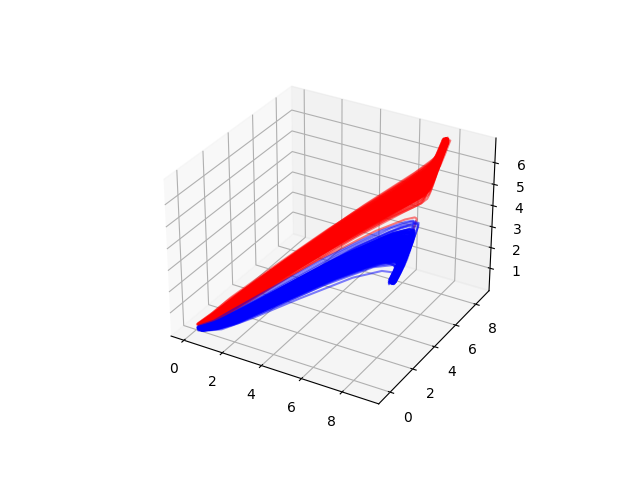

In [23]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds_orig = plot_preds(simple_rnn, inputs, directions)

In [24]:
target_accuracy(preds_orig, target_directions=directions)

0.998046875

# Heatmap of weights

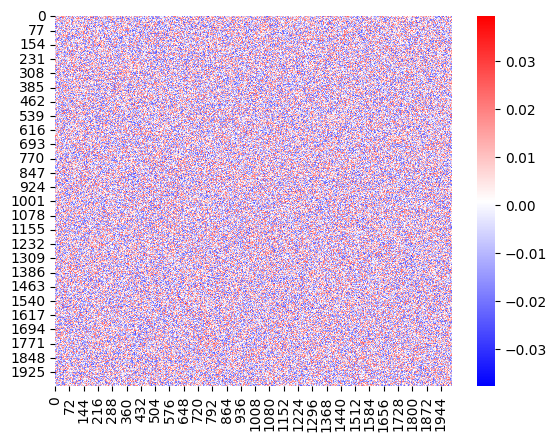

In [25]:
%matplotlib inline

sns.heatmap(simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

## Save the model first before pruning so we can have a copy

In [26]:
torch.save(simple_rnn.state_dict(), "./simple_rnn_2000.pt")

In [27]:
def get_orig_model() -> SimpleRNN:
    _m = SimpleRNN(
        input_size=4,
        hidden_size=2000,
        output_size=3,
    ).cuda()

    _m.load_state_dict(torch.load("./simple_rnn_2000.pt"))

    return _m

# Import pruning stuff

In [28]:
import torch.nn.utils.prune as prune

In [29]:
def plot_weights(models, fname: str = None):
    fig, axs = plt.subplots(nrows=3, ncols=4)
    fig.set_size_inches((8, 5))

    sns.heatmap(models[0].rnn.weight_hh_l0.detach().cpu().numpy(), cmap="seismic", ax=axs[0, 0], cbar=False)
    axs[0, 0].set_title("pre-pruned")

    for i, ax in tqdm(enumerate(axs.ravel()), total=11):
        if i == 0:
            ax.set_axis_off()
            continue  # skip the plot for the pre-pruned model
        if i == 11:
            break

        _pm = models[i - 1] # get one of the model instances for pruning

        # create a pruned model
        _pm.rnn = prune.random_unstructured(_pm.rnn, name="weight_hh_l0", amount=prune_fraction)

        sns.heatmap(_pm.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="seismic", ax=ax, cbar=False)
        ax.set_title(f"pruned ix: {i -1}")
        ax.set_axis_off()

    plt.tight_layout()
    if fname is not None:
        plt.savefig(f"./figs/{fname}.png", dpi=300)

## Prune and verify

In [30]:
%matplotlib inline

prune_fraction = 0.1

# create 10 model instances to prune
pruned_models_0_1: List[SimpleRNN] = [get_orig_model() for i in range(10)]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.07s/it]


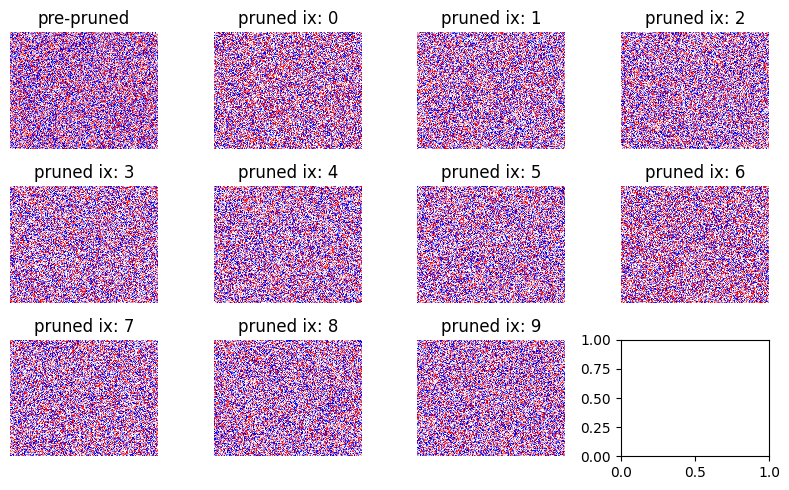

In [31]:
plot_weights([get_orig_model()] + pruned_models_0_1, "weights_10percent.png")
plt.show()

In [33]:
def plot_preds_grid(models, inputs, directions, fname: str = None):
    cmap = {
        0: "r",
        1: "b"
    }

    accs = list()

    fig, axs = plt.subplots(nrows=3, ncols=4, subplot_kw=dict(projection="3d"))
    fig.set_size_inches((12, 10))

    for i, (model, ax) in tqdm(enumerate(zip(models, axs.ravel()))):
        all_preds = torch.zeros(inputs.shape[0], 150, 3).cuda()

        hidden_prev = torch.zeros(1, inputs.shape[0], model.hidden_size).cuda()

        for timepoint in range(150):
            pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
            all_preds[:, timepoint, :] = pred[0, :, 0, :]

        for p, d in zip(all_preds, directions):
            p = p.detach().cpu().numpy()
            ax.plot(p[:, 0], p[:, 1], p[:, 2], cmap[d], alpha=0.5)
        acc = target_accuracy(all_preds.detach().cpu().numpy(), directions)
        ax.set_title(f"{acc * 100:.2f}%")
        
        if i == 10:
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
        
        accs.append(accs)
        
    if fname is not None:
        plt.savefig(f"./figs/{fname}.png", dpi=300)
        
    return accs

# Predictions with pruned model!

11it [00:03,  3.31it/s]


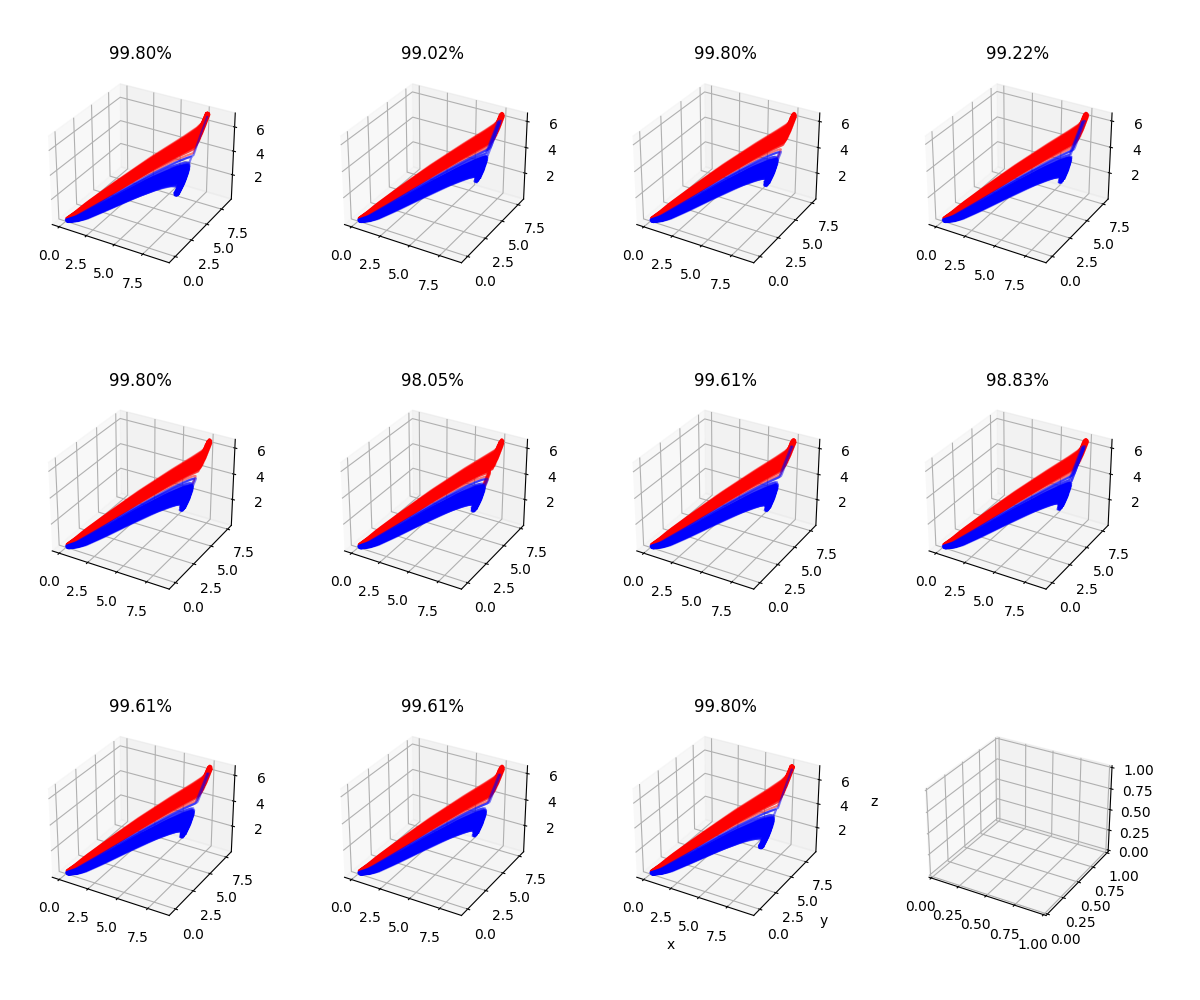

In [34]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_1

accs_0_1 = plot_preds_grid(models, inputs, directions, fname="10perecent_trajs")
plt.tight_layout()
plt.show()

In [35]:
accs_all = list()
accs_all.append(accs_0_1)

# Prune 20%

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.92s/it]


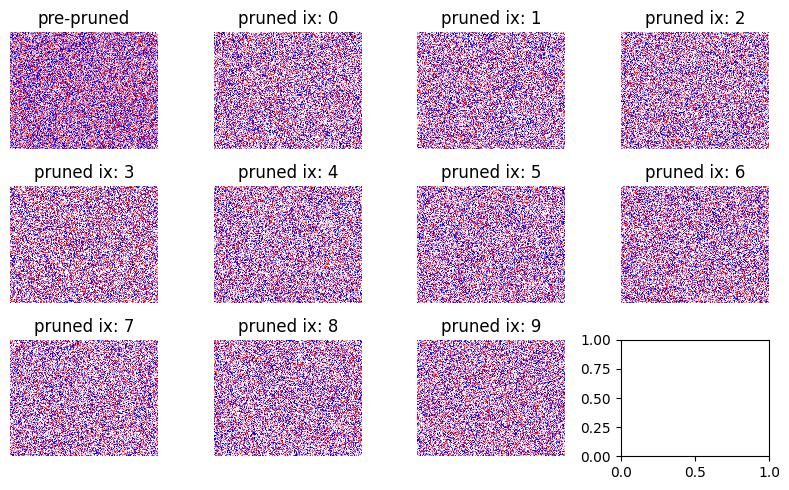

In [36]:
%matplotlib inline

prune_fraction = 0.2

# create 10 model instances to prune
pruned_models_0_2: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_2, "weights_20percent")
plt.show()

11it [00:03,  3.15it/s]


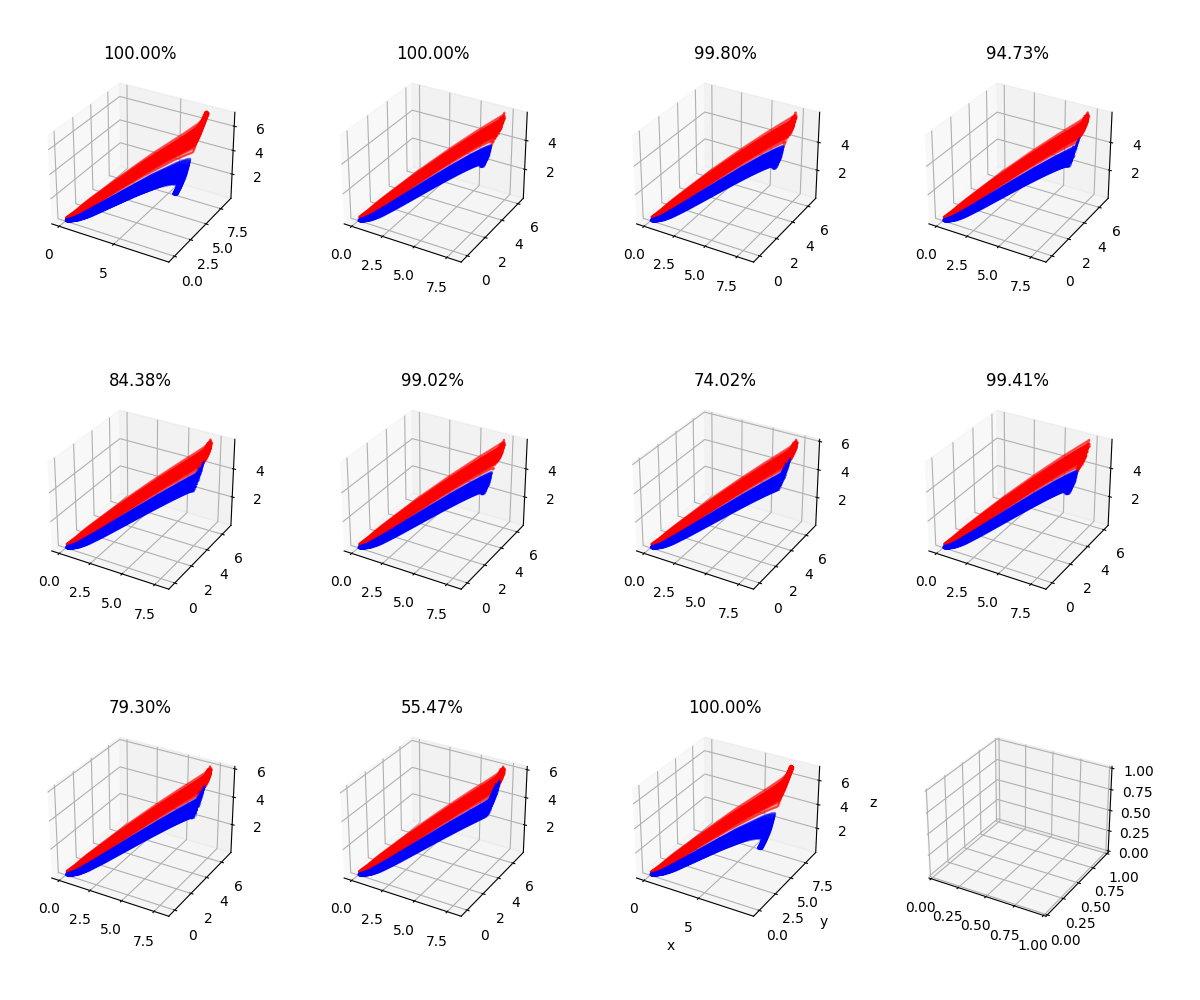

In [37]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_2

accs_0_2 = plot_preds_grid(models, inputs, directions, fname="20perecent_trajs")
plt.tight_layout()
plt.show()

# Prune 35%

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.95s/it]


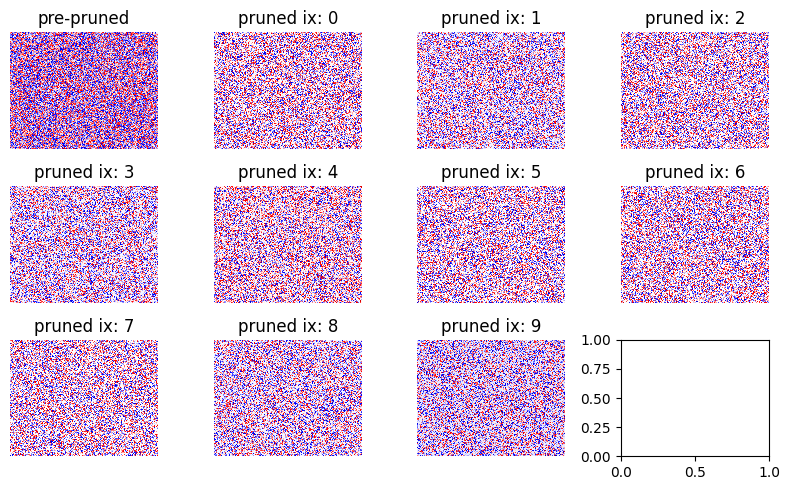

In [38]:
%matplotlib inline

prune_fraction = 0.35

# create 10 model instances to prune
pruned_models_0_35: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_35, "weights_35percent")
plt.show()

11it [00:03,  2.90it/s]


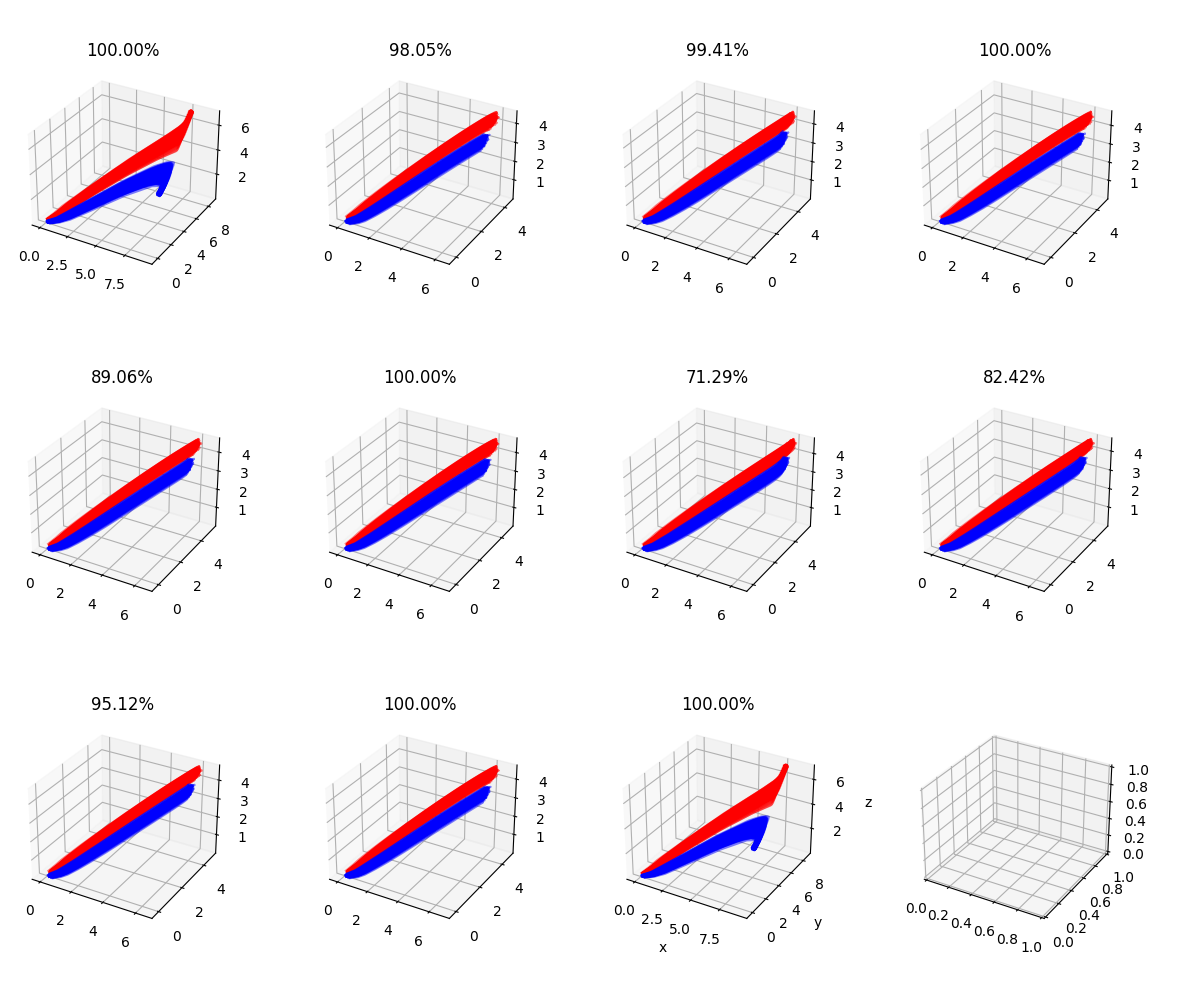

In [39]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_35

accs_0_35 = plot_preds_grid(models, inputs, directions, fname="35perecent_trajs")
plt.tight_layout()
plt.show()

# Prune 50%

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.03s/it]


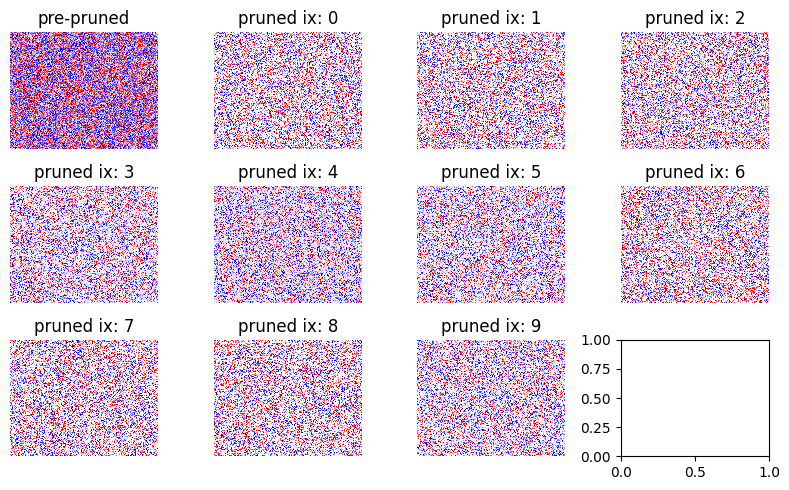

In [40]:
%matplotlib inline

prune_fraction = 0.50

# create 10 model instances to prune
pruned_models_0_50: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_50, "weights_50percent")
plt.show()

11it [00:03,  3.02it/s]


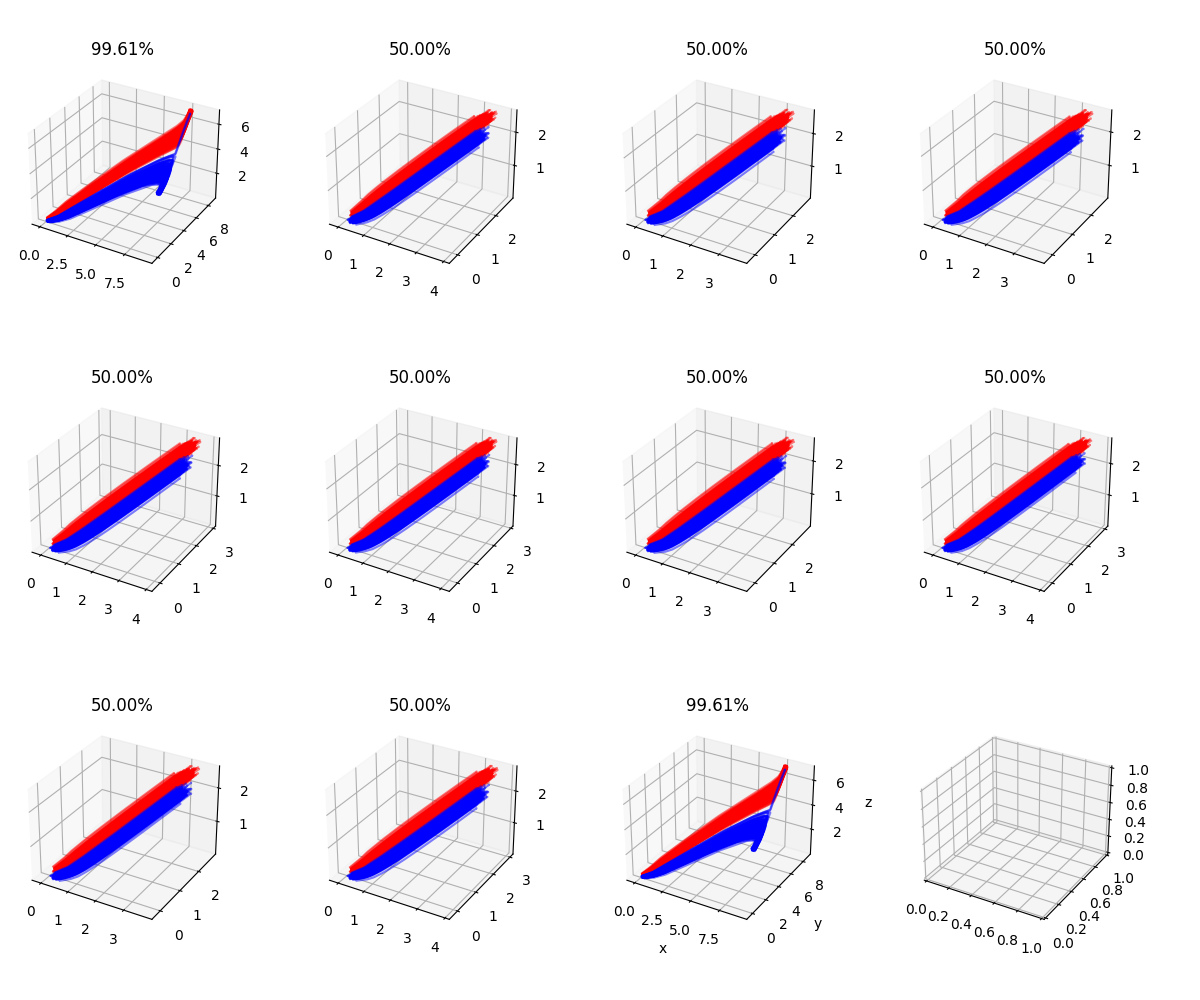

In [41]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_50

accs_0_50 = plot_preds_grid(models, inputs, directions, fname="50perecent_trajs")
plt.tight_layout()
plt.show()

# Choose some models to retrain
# Models with progressively worse accuracy to see how they recover

In [42]:
retrain_01 = pruned_models_0_1[4]  # a model with 98.05 accuracy
retrain_02 = pruned_models_0_2[3]  # model with 84.8% accuracy
retrain_035 = pruned_models_0_35[5] # model with 71.29% accuracy
retain_05 = pruned_models_0_50[0]  # model with 50% accuracy

# Retrain

In [54]:
lr = 0.0001

retrain_01, ls, ac = train(
    model=retrain_01,
    targets=all_targets,
    optimizer=optim.Adam(retrain_01.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=100,
    gradient_ascent=False,
    return_accuracy=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.39it/s]


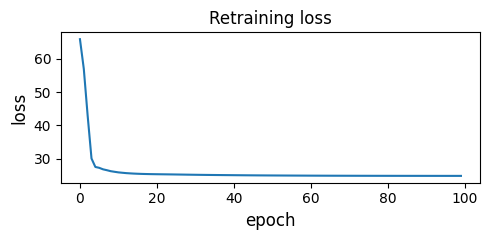

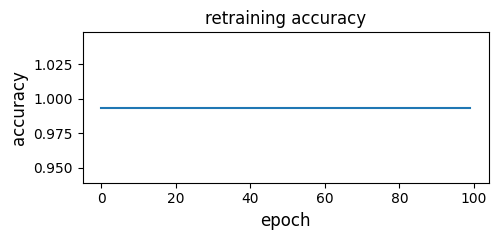

In [67]:
%matplotlib inline
fig = plt.figure(figsize=(5, 2.5))
plt.plot(ls)
plt.title("Retraining loss")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("loss", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/loss_retrain_10.png")
plt.show()

fig = plt.figure(figsize=(5, 2.5))
plt.plot(ac)
plt.title("retraining accuracy")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("accuracy", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/acc_retrain_10.png")
plt.show()

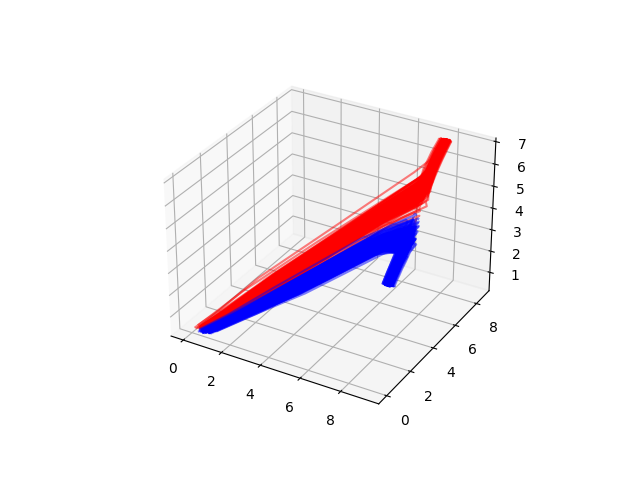

In [86]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds = plot_preds(retrain_01, inputs, directions)
plt.savefig("./figs/retrain_10.png")

### Accracy after retraining

In [87]:
target_accuracy(preds, target_directions=directions)

0.998046875

In [72]:
lr = 0.0001

retrain_02, ls, ac = train(
    model=retrain_02,
    targets=all_targets,
    optimizer=optim.Adam(retrain_02.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=100,
    gradient_ascent=False,
    return_accuracy=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.33it/s]


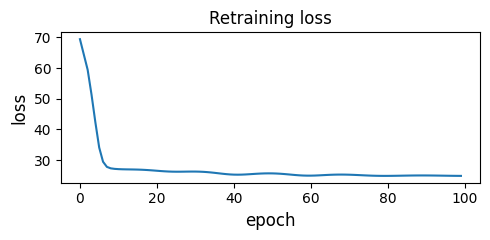

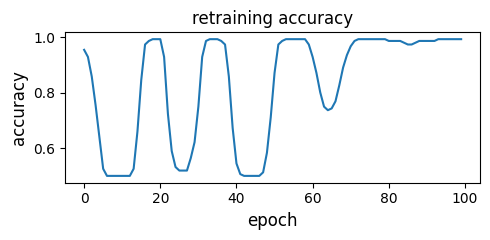

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(5, 2.5))
plt.plot(ls)
plt.title("Retraining loss")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("loss", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/loss_retrain_20.png")
plt.show()

fig = plt.figure(figsize=(5, 2.5))
plt.plot(ac)
plt.title("retraining accuracy")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("accuracy", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/acc_retrain_20.png")
plt.show()

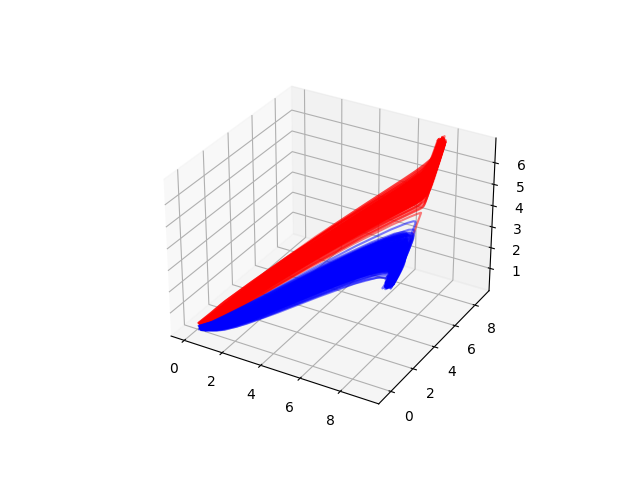

In [88]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds = plot_preds(retrain_02, inputs, directions)
plt.savefig("./figs/retrain_20.png")

### Accracy after retraining

In [89]:
target_accuracy(preds, target_directions=directions)

0.998046875

In [78]:
lr = 0.0001

retrain_035, ls, ac = train(
    model=retrain_035,
    targets=all_targets,
    optimizer=optim.Adam(retrain_035.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=300,
    gradient_ascent=False,
    return_accuracy=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.58it/s]


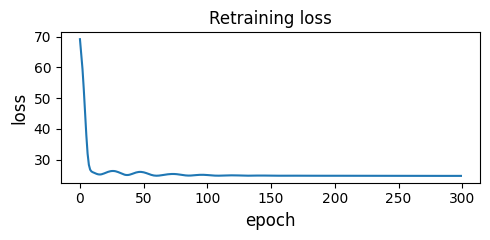

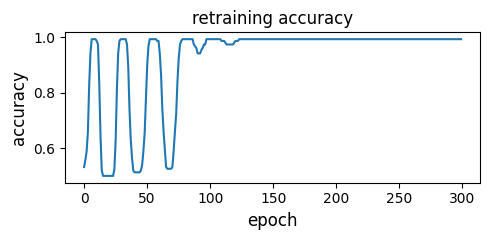

In [79]:
%matplotlib inline
fig = plt.figure(figsize=(5, 2.5))
plt.plot(ls)
plt.title("Retraining loss")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("loss", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/loss_retrain_35.png")
plt.show()

fig = plt.figure(figsize=(5, 2.5))
plt.plot(ac)
plt.title("retraining accuracy")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("accuracy", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/acc_retrain_35.png")
plt.show()

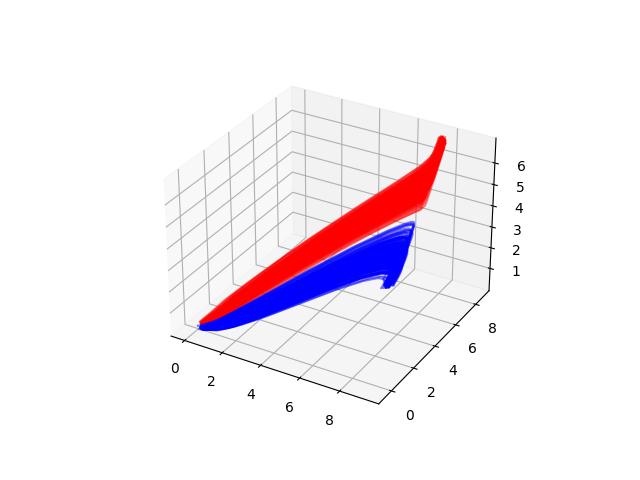

In [90]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds = plot_preds(retrain_02, inputs, directions)
plt.savefig("./figs/retrain_30.png")

### Accracy after retraining

In [91]:
target_accuracy(preds, target_directions=directions)

1.0

In [80]:
lr = 0.0001

retain_05, ls, ac = train(
    model=retain_05,
    targets=all_targets,
    optimizer=optim.Adam(retain_05.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=500,
    gradient_ascent=False,
    return_accuracy=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.66it/s]


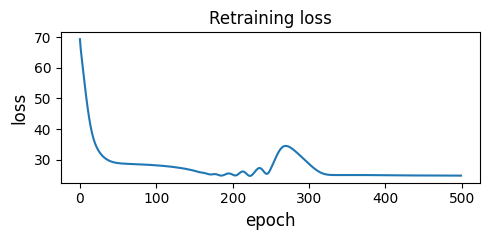

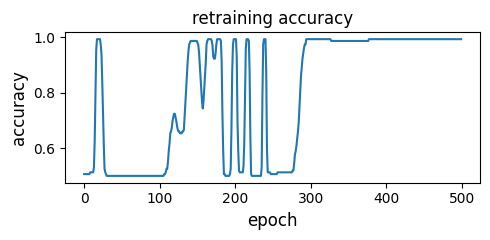

In [82]:
%matplotlib inline
fig = plt.figure(figsize=(5, 2.5))
plt.plot(ls)
plt.title("Retraining loss")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("loss", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/loss_retrain_50.png")
plt.show()


fig = plt.figure(figsize=(5, 2.5))
plt.plot(ac)
plt.title("retraining accuracy")
plt.xlabel("epoch", fontdict={"fontsize": 12})
plt.ylabel("accuracy", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig("./figs/acc_retrain_50.png")
plt.show()

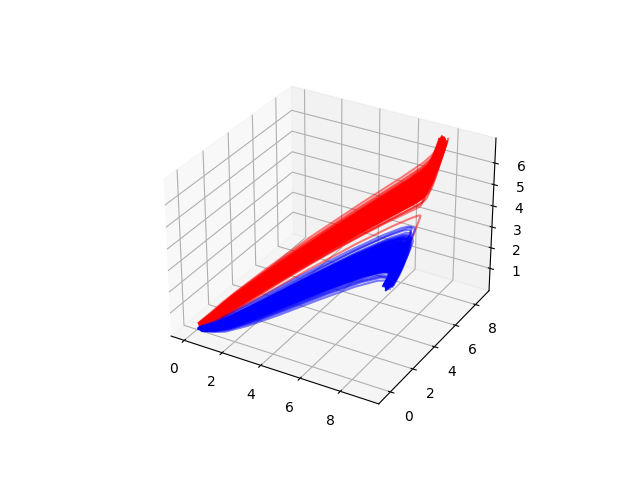

In [84]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds = plot_preds(retrain_02, inputs, directions)
plt.savefig("./figs/retrain_50.png")

### Accracy after retraining

In [85]:
target_accuracy(preds, target_directions=directions)

0.998046875

# Use one of the 50% pruned models to use PCA to understand how the neural activation changes after pruning the model and after retraining

In [122]:
# Exactly same as our class before but return the RNN output so we can do PCA

class SimpleRNNPCA(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNNPCA, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        rnn_out, hidden_prev = self.rnn(x, hidden_prev)
        out = self.linear(rnn_out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev, rnn_out

In [123]:
def neural_activity(model, inputs):
    all_activity = list()
    hidden_prev = torch.zeros(1, 512, model.hidden_size).cuda()
    for _ in range(150):  # length of each traj is 150
        pred, hidden_prev, rnn_out_t = model(inputs.cuda(), hidden_prev.cuda())
        all_activity.append(rnn_out_t.detach().cpu().numpy())
    return all_activity

In [128]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

In [139]:
def plot_pca(model):
    n_points = 512
    directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
    inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

    activity = neural_activity(model, inputs)
    
    activity = np.hstack(activity)
    act = np.zeros(shape=(512*150, 2000), dtype=activity.dtype)

    for i in range(activity.shape[0]):
        act[i * 150:(i + 1) * 150, :] = activity[i, :, :]

    pca = PCA(n_components=2)

    act_s = QuantileTransformer().fit_transform(act)
    transform = pca.fit_transform(act_s)

    %matplotlib inline

    cmap = {
        0: "r",
        1: "b"
    }


    for i in range(512):
        X_ = pca.transform(act_s[i * 150:(i + 1) * 150, :])
        plt.scatter(X_[:, 0], X_[:, 1], c=cmap[directions[i]], s=2)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA of left vs. right neural activiation")
    plt.show()

    for i in range(512):
        X_ = pca.transform(act_s[i * 150:(i + 1) * 150, :])
        s = plt.scatter(X_[:, 0], X_[:, 1], c=np.arange(150), cmap="turbo", s=2)
        plt.title("PCA neural activation, color indicates timestep")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
    plt.show()

In [140]:
orig_rnn_pca = SimpleRNNPCA(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

# orignal model

# this model has 82% accuracy
orig_rnn_pca.load_state_dict(simple_rnn.state_dict())  

<All keys matched successfully>

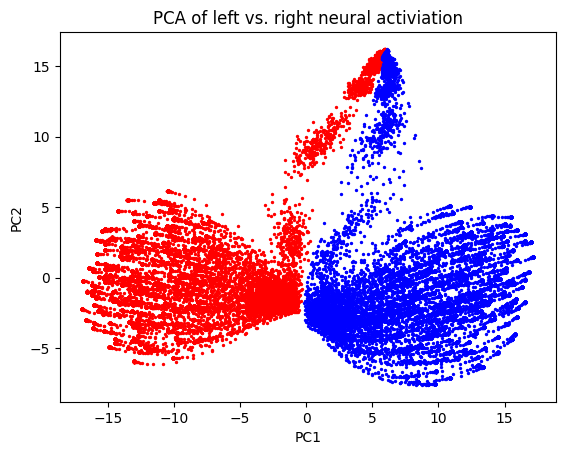

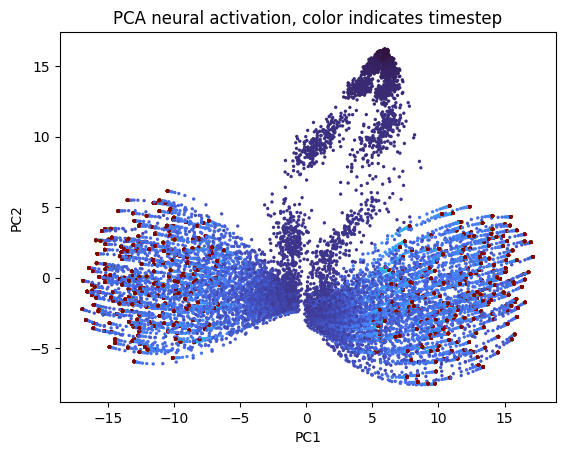

In [141]:
plot_pca(orig_rnn_pca)

In [145]:
rnn_pca = SimpleRNNPCA(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

# this model has 50% accuracy
pruned_models_0_50[3].rnn = prune.remove(pruned_models_0_50[3].rnn, "weight_hh_l0")
rnn_pca.load_state_dict(pruned_models_0_50[3].state_dict())  

<All keys matched successfully>

In [146]:
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

activity = neural_activity(rnn_pca, inputs)

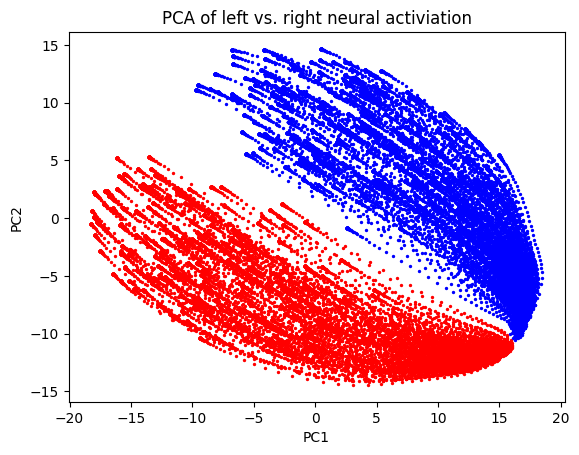

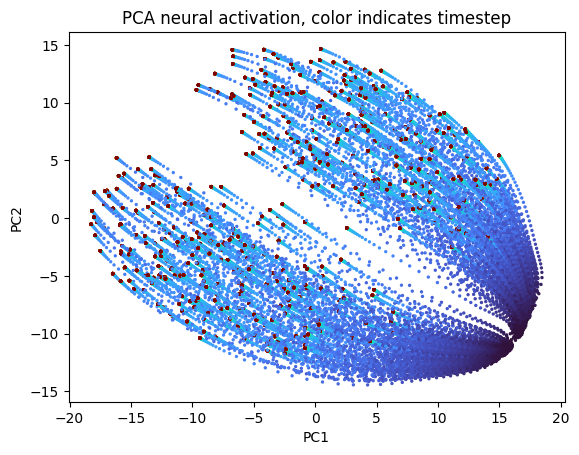

In [148]:
plot_pca(rnn_pca)

# Modified train because model returns RNN output

In [152]:
def target_accuracy_model(model):
    all_preds = torch.zeros(156, 150, 3).cuda()
    inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)

    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()
    
    for timepoint in range(150):
        pred, hidden_prev, _ = model(inputs.cuda(), hidden_prev.cuda())
        all_preds[:, timepoint, :] = pred[0, :, 0, :]
        
    return target_accuracy(all_preds.detach().cpu().numpy(), train_directions)

def train(
    model: SimpleRNN,
    targets: torch.Tensor,
    optimizer: optim.Optimizer,
    lr0: int,
    loss_func: callable,
    n_epochs: int,
    gradient_ascent: bool = False,
    return_accuracy: bool = False
) -> SimpleRNN:
    """
    Parameters
    ----------

    SimpleRNN model instance

    `all_targets` created above

    optimizer, Adam seems to work well
    
    lr0, initial learning rate

    loss function, just MSE for now
    
    Returns
    -------
    
    SimpleRNN model instance, losses
    """

    losses = list()
    accs = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()

    for n_epoch in tqdm(range(n_epochs)):
        # give position and target direction [x, y, z, direction] of only first index!
        x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4) # [n_trajs, 1, (x0, y0, z0, dir_0)]
        y = all_targets.swapaxes(1, 2)[:, :, :3]

        output, hidden_prev, _ = model(x.cuda(), hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        if not gradient_ascent:
            loss = loss_func(output, y.cuda())
        else:
            loss = make_ascent(loss_func(output, y.cuda()))
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduces learnign rate every 250 epochs, this helps A LOT
        if n_epoch % 250 == 0:
            lr0 = lr0 / 10
            for g in optimizer.param_groups:
                g['lr'] = lr0

        losses.append(loss.detach().cpu().numpy().item())
        
        if return_accuracy:
            accs.append(target_accuracy_model(model))
        else:
            accs = None
            
    
    return model, losses, accs

In [153]:
lr = 0.0001

rnn_pca, ls, ac = train(
    model=rnn_pca,
    targets=all_targets,
    optimizer=optim.Adam(rnn_pca.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=500,
    gradient_ascent=False,
    return_accuracy=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.53it/s]


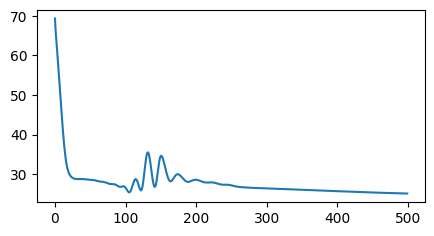

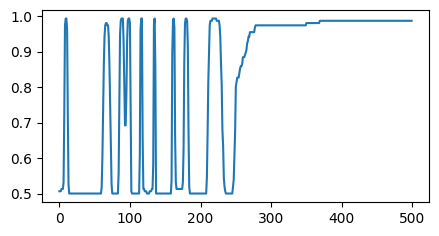

In [155]:
%matplotlib inline
fig = plt.figure(figsize=(5, 2.5))
plt.plot(ls)

plt.show()


fig = plt.figure(figsize=(5, 2.5))
plt.plot(ac)
plt.show()

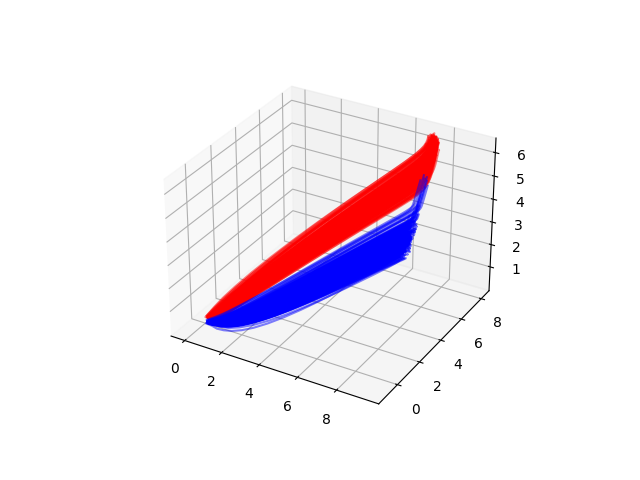

In [157]:
%matplotlib ipympl

def plot_preds(model, inputs, directions):
    all_preds = torch.zeros(inputs.shape[0], 150, 3).cuda()

    hidden_prev = torch.zeros(1, inputs.shape[0], model.hidden_size).cuda()

    for timepoint in range(150):
        pred, hidden_prev, _ = model(inputs.cuda(), hidden_prev.cuda())
        all_preds[:, timepoint, :] = pred[0, :, 0, :]

    cmap = {
        0: "r",
        1: "b"
    }

    ax = plt.figure().add_subplot(projection='3d')

    for p, d in zip(all_preds, directions):
        p = p.detach().cpu().numpy()
        ax.plot(p[:, 0], p[:, 1], p[:, 2], cmap[d], alpha=0.5)
    return all_preds.detach().cpu().numpy()

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds = plot_preds(rnn_pca, inputs, directions)

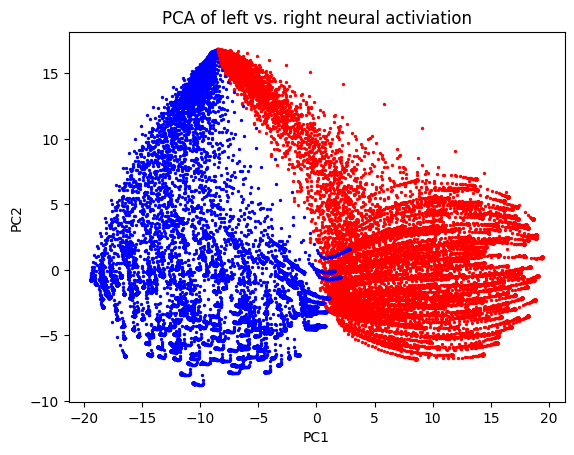

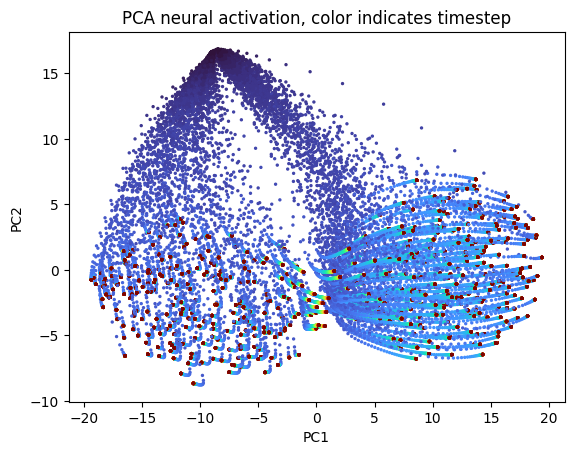

In [158]:
plot_pca(rnn_pca)